In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mean_squared_error as mse
from dafi import random_field as rf

In [2]:
degfx = degfy = 50       # numbers of degress of freedom in x,y directions
lengthx = 1; lengthy = 1

# areas
deltax = lengthx / degfx
deltay = lengthy / degfy
area = deltax * deltay

xpos, ypos = np.meshgrid(np.linspace(0, lengthx, degfx+1), np.linspace(0, lengthy, degfy+1))
xpos = np.atleast_2d(xpos.ravel()).T
ypos = np.atleast_2d(ypos.ravel()).T
coords = np.hstack([xpos, ypos])

In [3]:
mean = 1.0
cov = rf.covariance.generate_cov('sqrexp', stddev=1.0, coords=coords, length_scales=[0.1, 0.1])
nsamples = 26
samples, nmodes = rf.gp_samples_kl_coverage(cov,
                                            nsamples,
                                            area, 
                                            coverage=0.99, 
                                            mean=mean,
                                            max_modes=30)

In [4]:
print(samples.shape,nmodes)

(2601, 26) 30


In [5]:
utrue = samples[:,0]
uens = samples[:,1:]

In [6]:

class fmodel():
    def __init__(self,**kwargs):
        """
        Heat Equation solved with finite elements method via fenics

        Parameters:
        -------------------------------
        param: T:            final time
        param: num_steps:    number of time steps
        param: dt:           time step size
        param: alpha:        parameter alpha
        param: beta:         parameter beta
        param: nx = ny:      numbers of degress of freedom in x,y directions
        param: unit:         initial value
        param: snaps:        list for snap shots of solution
        """

        self.__dict__.update((param, value) for param,value in kwargs.items()) 

        set_log_level(30)
        
    def _run(self):
        """
        """

        # Create mesh and define function space
        mesh = UnitSquareMesh(self.nx, self.ny)
        V = FunctionSpace(mesh, 'P', 1)

        # Define boundary condition
        u_D = Expression('1 + x[0]*x[0] + alpha*x[1]*x[1] + beta*t',
                         degree=2, alpha=alpha, beta=beta, t=0)

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)

        # Define initial value
        u_n = interpolate(u_D, V)
        u_n.vector().set_local(uinit)

        #u_n = project(u_D, V)

        # Define variational problem
        u = TrialFunction(V)
        v = TestFunction(V)
        f = Constant(self.beta - 2 - 2*self.alpha)

        F = u*v*dx + self.dt*dot(grad(u), grad(v))*dx - (u_n + self.dt*f)*v*dx
        a, L = lhs(F), rhs(F)

        # Time-stepping
        u = Function(V)
        t = 0

        for n in range(num_steps):

            t += self.dt; u_D.t = t                           # Update current time

            solve(a == L, u, bc)                         # Compute solution
            self.snaps.append(u.vector().get_local())         # save solution
            u_e = interpolate(u_D, V)                    # Compute error at vertices  
            u_n.assign(u)                                 # Update previous solution

        return u, snaps

# Hold plot
# interactive()

In [13]:
params = {"T":10.0,        
        "num_steps":50,
        "dt": 10.0/50.0,
        "alpha": 3,
        "beta": 1.2,      
        "nx":50,
        "ny": 50,     
        "snaps": list()
         "utrue":None}

In [7]:
heat = fmodel(**params)
usol, snapshots = heat.run()

In [8]:
snapshots = np.asarray(snapshots)
ubar = snapshots.mean(axis=1)

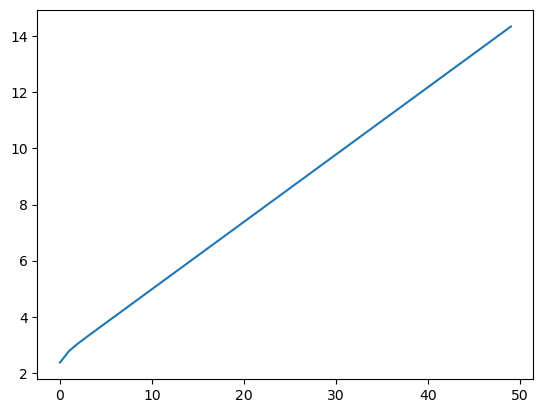

In [9]:
plt.plot(ubar)
plt.show()

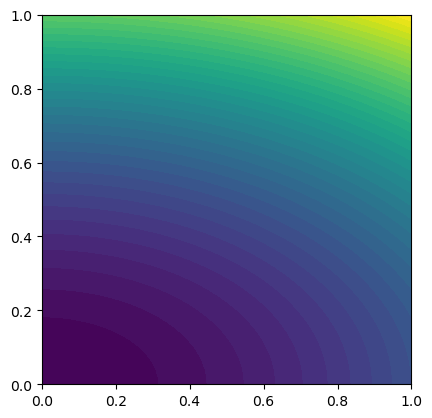

In [10]:
# Plot true solution
plot(usol)
plt.show()

In [33]:
snapshots.shape

(50, 2601)

In [34]:
# create "true" observations
obs = [23,237,888,1065,2235]
observations = snapshots[:,obs]
noise = (0.01)**2 * np.random.normal(size=observations.shape[0])
observations = observations + noise[:,np.newaxis]

(50,)

NameError: name 'nx' is not defined

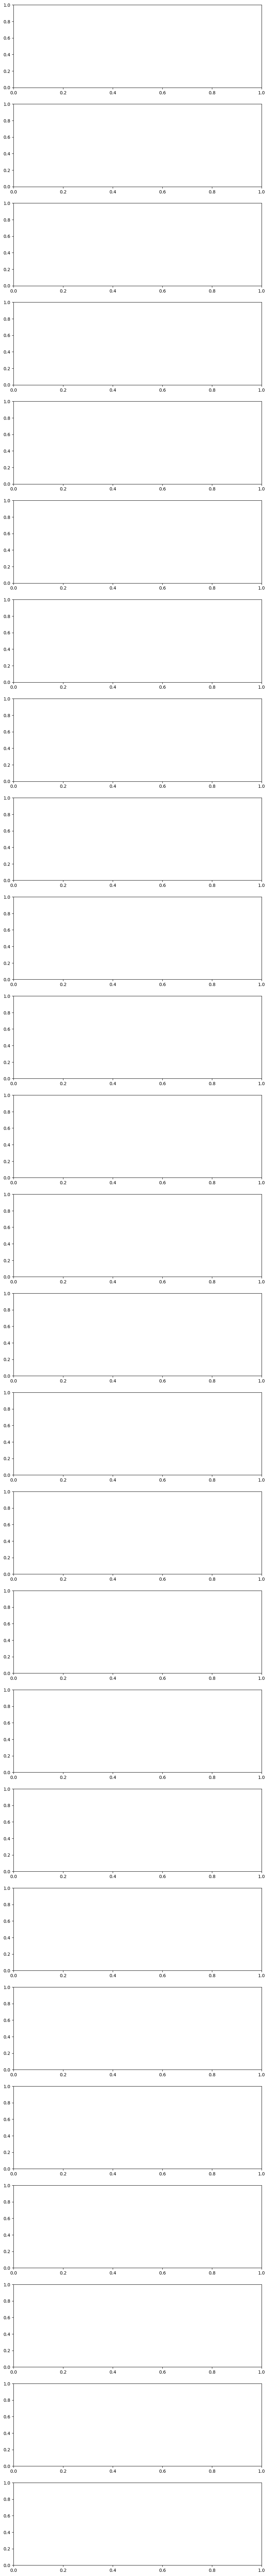

In [10]:
# plot
fig, axs = plt.subplots(nsamples, 1, figsize=(10, 4*nsamples))
for i in range(nsamples):
    im = axs[i].matshow(np.flipud(samples[:,i].reshape([nx+1,ny+1])), extent=[0,Lx,0,Ly], interpolation='bilinear', vmin=-2.0, vmax=2.0, cmap='RdBu')
    axs[i].xaxis.tick_bottom()
    axs[i].set_xlabel('Cell Center Coordinate $x$')
    axs[i].set_ylabel('Cell Center Coordinate $y$')
    axs[i].axis('equal')
    divider = make_axes_locatable(axs[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)